# Задание на лабораторную работу 1

Необходимо для двух зависимых признаков оценить параметры регрессии с помощью МНК, подобрав экспериментально степень многочлена регрессии, посчитать коэффициент детерминации.

Для остатков проверить гипотезу об их гауссовости.

Добавить в выборку выбросы и оценить параметры регрессии с помощью МНК, Тьюки и Хьюбера.

В качестве признаков возьмем Индекс свободы прессы ([2021 World Press Freedom Index](https://rsf.org/en/ranking)) и Индекс человеческого развития ([Human Development Report 2020](https://report.hdr.undp.org/))

In [1]:
from typing import Tuple, Any, List, Dict
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
import re
import logging
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import matplotlib.pyplot as plt

Для получения данных об Индексе свободы прессы воспользуемся официальным сайтом https://rsf.org/en/ranking

In [2]:
session = requests.Session()
url = 'https://rsf.org/en/ranking'
headers = {
    "accept": "text/html,application/xhtml+xml,application/xml;" +
        "q=0.9,image/avif,image/webp,image/apng,"
        "*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    "accept-encoding": "gzip, deflate, br",
    "accept-language": "ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36",
    "referer": 'https://rsf.org/en/ranking',
    "cookie": ""
}
response = session.request(
    'GET',
    url,
    headers = headers
)
print(len(response.text))

1358820


In [3]:
soup = BeautifulSoup(response.text, features="html.parser")

# данные по странам
countries_WPFI_list = soup.find_all("li", {"class": "country_name_item"})
countries = []
WPF_index = []

# собираем названия стран и соответствующие индексы
for countries_WPFI in countries_WPFI_list:
    country_name = countries_WPFI.find("span", {"class": "ranking-map__panel-name"}).text
    country_index = float(countries_WPFI.find("span", {"class": "ranking-map__panel-score"}).text)
    countries.append(country_name)
    WPF_index.append(country_index)

countries_WPFI_dict = {
    'country_name': countries,
    'WPF_index': WPF_index
}

# собираем датафрейм
country_index_df = pd.DataFrame(countries_WPFI_dict)
country_index_df.head()

,country_name,WPF_index
0,Norway,6.72
1,Finland,6.99
2,Sweden,7.24
3,Denmark,8.57
4,Costa Rica,8.76


In [4]:
country_index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  180 non-null    object 
 1   WPF_index     180 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.9+ KB


Для получения данных об индексе человеческого развития воспользуемся Википедией, т.к. сайт ООН красивый, но непрактичный - https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index

In [5]:
session = requests.Session()
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index'

response = session.request(
    'GET',
    url,
    headers = headers
)
print(len(response.text))

520898


In [6]:
soup = BeautifulSoup(response.text, features="html.parser")

# данные по странам
HDI_table = soup.find("table").tbody
countries_HDI_list = HDI_table.find_all("tr")
countries = []
HumanDev_index = []

for countries_HDI in countries_HDI_list:
    try:
        country_name = countries_HDI.find("th").a.text
        country_index = float(countries_HDI.find_all("td")[-2].text)
        countries.append(country_name)
        HumanDev_index.append(country_index)
    except Exception:
        pass

countries_HDI_dict = {
    'country_name': countries,
    'HumanDev_index': HumanDev_index
}

# собираем датафрейм
country_HDI_df = pd.DataFrame(countries_HDI_dict)
country_HDI_df.head()

,country_name,HumanDev_index
0,Norway,0.957
1,Ireland,0.955
2,Switzerland,0.955
3,Hong Kong,0.949
4,Iceland,0.949


In [7]:
country_HDI_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country_name    189 non-null    object 
 1   HumanDev_index  189 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.1+ KB


Объединяем данные из двух источников

In [8]:
combined_df = pd.merge(
    country_index_df,
    country_HDI_df,
    how="inner",
    on="country_name"
)
combined_df.head()

,country_name,WPF_index,HumanDev_index
0,Norway,6.72,0.957
1,Finland,6.99,0.938
2,Sweden,7.24,0.945
3,Denmark,8.57,0.940
4,Costa Rica,8.76,0.810


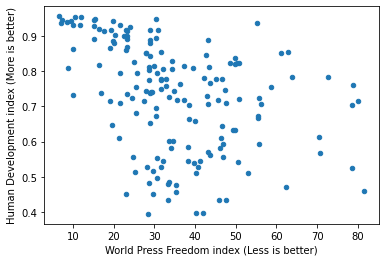

In [9]:
ax = combined_df.plot(
    x='WPF_index', 
    y='HumanDev_index', 
    kind='scatter', 
    xlabel='World Press Freedom index (Less is better)',
    ylabel='Human Development index (More is better)'
)
plt.show()

In [10]:
combined_df.corr()

,WPF_index,HumanDev_index
WPF_index,1.000000,-0.396891
HumanDev_index,-0.396891,1.000000


Стоит отметить не слишком высокую, но заметную отрицательную корреляцию

Постановка задачи:

Необходимо для двух зависимых признаков оценить параметры регрессии с помощью МНК,
подобрав экспериментально степень многочлена регрессии, посчитать коэффициент детерминации.

Для остатков проверить гипотезу об их гауссовости.
Оценить параметры регрессии с помощью МНК, Тьюки и Хьюбера.

In [25]:
from scipy.optimize import leastsq

In [27]:
def fit_func(coefs, x):
    """
    Функция создания полинома и вычисления его значения
    """
    f = np.polynomial.Polynomial(coefs)
    return f(x)


def residuals_func(coefs, y, x):
    """
    Функция определяет отклонение от значения в точке
    """
    ret = y - fit_func(coefs, x)
    return ret


# значения оси Х - индекс свободы прессы
x = combined_df.WPF_index.to_list()

# значения в точке - индекс развития
y = combined_df.HumanDev_index.to_list()

for i in range(1, 8):
    p_init = np.random.randn(i)
    plqs = leastsq(residuals_func, p_init, args=(y, x))
    plt.scatter(x, y, label='data')
    plt.scatter(x, fit_func(plsq[0], x), label='approximation')
    plt.legend()
    plt.show()

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [23]:
fit_func([7, 7], 7)
# f_y.fit(x=combined_df.WPF_index, y=combined_df.HumanDev_index)

56.0

In [15]:
help(np.polynomial.Polynomial)

Help on class Polynomial in module numpy.polynomial.polynomial:

class Polynomial(numpy.polynomial._polybase.ABCPolyBase)
 |  Polynomial(coef, domain=None, window=None)
 |  
 |  A power series class.
 |  
 |  The Polynomial class provides the standard Python numerical methods
 |  '+', '-', '*', '//', '%', 'divmod', '**', and '()' as well as the
 |  attributes and methods listed in the `ABCPolyBase` documentation.
 |  
 |  Parameters
 |  ----------
 |  coef : array_like
 |      Polynomial coefficients in order of increasing degree, i.e.,
 |      ``(1, 2, 3)`` give ``1 + 2*x + 3*x**2``.
 |  domain : (2,) array_like, optional
 |      Domain to use. The interval ``[domain[0], domain[1]]`` is mapped
 |      to the interval ``[window[0], window[1]]`` by shifting and scaling.
 |      The default value is [-1, 1].
 |  window : (2,) array_like, optional
 |      Window, see `domain` for its use. The default value is [-1, 1].
 |  
 |      .. versionadded:: 1.6.0
 |  
 |  Method resolution order:
